In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle
import tensorflow as tf
import sys
import os

In [4]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = np.array([iv,vaso])

# the non-static variables
variable_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                    20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45, 47]

In [13]:
def load_data_test():
    dire = 'converted_data/'

    train_feat_zeros = np.loadtxt(dire + 'X_train_hist_zeros.txt')
    train_targets = np.loadtxt(dire + 'Y_train_hist_zeros.txt')
    print ("Loaded train_zeros")

    val_feat_zeros = np.loadtxt(dire + 'X_val_hist_zeros.txt')
    val_targets = np.loadtxt(dire + 'Y_val_hist_zeros.txt')
    print ("Loaded val_zeros")

    return train_feat_zeros,train_targets, val_feat_zeros, val_targets

In [29]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control
X_train, Y_train,  X_val, Y_val = load_data_test()

Loaded train_zeros
Loaded val_zeros


In [30]:
df_train = pd.read_csv('../data/rl_train_set_unscaled.csv')
df_val = pd.read_csv('../data/rl_val_set_unscaled.csv')

In [177]:
hidden_1_size = 128
hidden_2_size = 32
class EnvModel():
    def __init__(self, sess):
        self.sess = sess

        self.iv_mean = float(np.load('iv_mean.npy'))
        self.iv_std = float(np.load('iv_std.npy'))

        self.vaso_mean = float(np.load('vaso_mean.npy'))
        self.vaso_std = float(np.load('vaso_std.npy'))

        self.sofa_index = 179 # state vector has 150 elements from previous timestep; 30 elements in is SOFA. index = (150+30) -1
        self.lact_index = 152 # state vector has 150 elements from previous timestep; 3 elements in is SOFA. index = (150+3) -1

        # load in the saved factors for the rewards
        self.sofa_mean = float(np.load('../data/sofa_mean.npy'))
        self.sofa_std = float(np.load('../data/sofa_std.npy'))
        self.lact_mean = float(np.load('../data/lact_mean.npy'))
        self.lact_std = float(np.load('../data/lact_std.npy'))


        with tf.variable_scope('envmodel2'):
            self.phase = False
            
            self.input_size = 200

            self.target_size = 43

            self.cur_state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="cur_state")
            
            self.fc_1 = tf.contrib.layers.fully_connected(self.cur_state, hidden_1_size, activation_fn=tf.nn.relu)
            self.fc_1_bn = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
            self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1_bn, hidden_2_size, activation_fn=tf.nn.relu)
            self.fc_2_bn = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
            
            self.output = tf.contrib.layers.fully_connected(self.fc_2_bn, self.target_size, activation_fn = None)

            # output is of dimension (bs, 43)
            # last entry is 'died in hospital'.

        self._do_restore()

    def _do_restore(self):
        params_env = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='envmodel2')

        env_model_saved_names = [u'fully_connected/weights', u'fully_connected/biases', 
        u'BatchNorm/beta', u'BatchNorm/gamma', u'BatchNorm/moving_mean', u'BatchNorm/moving_variance', 
        u'fully_connected_1/weights', u'fully_connected_1/biases', 
        u'BatchNorm_1/beta', u'BatchNorm_1/gamma', u'BatchNorm_1/moving_mean', u'BatchNorm_1/moving_variance', 
        u'fully_connected_2/weights', u'fully_connected_2/biases']

        restore_dict_env = {i:v for (i,v) in zip(env_model_saved_names, params_env)}
        restorer_env = tf.train.Saver(restore_dict_env)

        # TODO sort out the path below
        restorer_env.restore(self.sess, './env_model_reg/ckpt')



    # need to be able to return next state, of dimension (bs, 198) with the correct stacking
    def step(self,cur_state, action, terminal=False):
        
        # print("SHAPE ", action.shape)
        # run a forward pass to get the output (delta_t)
        if cur_state.ndim <2: 
            cur_state = cur_state[np.newaxis,:]
        
#         action_as_arr = np.array([inv_action_map[a] for a in action])
        action_as_arr = action

        # normalise IV
        action_as_arr[:,0] = (action_as_arr[:,0] - self.iv_mean)/self.iv_std
        action_as_arr[:,1] = (action_as_arr[:,1] - self.vaso_mean)/self.vaso_std
        
#         print(action_as_arr)
        
#         print(cur_state.shape, action_as_arr.shape)
        inp = np.hstack([cur_state, action_as_arr])
        delta_t = self.sess.run(self.output, feed_dict={self.cur_state:inp})
        
        # ADD NOISE: variance 0.001
#         delta_t += np.random.normal(0,0.03,size=delta_t.shape)
        
        delta_t_state = delta_t[:,:-1] # last entry is mortality flag
        next_state = self._get_next_state(delta_t_state, cur_state, action)
        # TODO CHANGE THE BELOW TO BE [bs x 1] NOT [1 x bs]
        reward = np.expand_dims(np.array(self._get_reward(cur_state, next_state)), axis=1)
        term_reward = np.expand_dims(np.array(self._get_term_reward(delta_t)), axis=1)
        
        # if terminal:
        #     reward += term_reward
        
#         print("REWARD ", np.mean(reward))
        
        return next_state, reward


    def _get_next_state(self,delta_t, cur_state, action):
        
        # print("Action shape ", action.shape)
        # cur_state is batch_size x 198

        # new_state_with_hist is bs x 148
        # print(cur_state.shape)
        new_state_with_hist = cur_state[:, 50:]
        s_t_next = np.copy(new_state_with_hist[:, 100:])
        # print(s_t_next.shape)
        # print(s_t_next[range(len(s_t_next)), variable_indices].shape)
        # print(delta_t.shape)
        s_t_next[:, variable_indices] += delta_t

#         action_as_arr = np.array([inv_action_map[a] for a in action])
        action_as_arr = action

        # normalise IV
        action_as_arr[:,0] = (action_as_arr[:,0] - self.iv_mean)/self.iv_std
        action_as_arr[:,1] = (action_as_arr[:,1] - self.vaso_mean)/self.vaso_std
    
        
        new_state_with_hist = np.hstack([new_state_with_hist, action_as_arr])
        
        # stack this next state onto the new_state_with_hist
        new_state_with_hist = np.append(new_state_with_hist, s_t_next, axis=1)
        return new_state_with_hist

    def _get_reward(self, cur_state, next_state):
        c0 = -1.0/4
        c1 = -2/4
        c2 = -2
        
        #grab the right cols
        sofa_now = cur_state[:, self.sofa_index]
        lact_now = cur_state[:, self.lact_index]
        
        sofa_next = next_state[:, self.sofa_index]
        lact_next = next_state[:, self.lact_index]
        
        # unscale the sofa/lactate
        sofa_now = sofa_now * self.sofa_std + self.sofa_mean
        sofa_next = sofa_next * self.sofa_std + self.sofa_mean
        
        lact_now = lact_now * self.lact_std + self.lact_mean
        lact_next = lact_next * self.lact_std + self.lact_mean
        
#         print("SOFA NOW %f, LACTATE NOW %f" % (np.mean(sofa_now), np.mean(lact_now)))
        
#         print("SOFA NEXT %f, LACTATE NEXT %f" % (np.mean(sofa_next), np.mean(lact_next)))
        
        #reward function: R(t) = c0*(T.tanh(sofa_now)) + c1(sofa_next-sofa_now) + c2*T.tanh(lact_next-lact_now)
        # TODO do we want to tanh the change in SOFA score too?
        # reward = c0*np.tanh(sofa_now) + c1*(sofa_next-sofa_now) + c2*np.tanh(lact_next-lact_now)
        reward = c1*(sofa_next-sofa_now)
        return reward

    def _get_term_reward(self,delta_t):
        # terminal reward is the final element of delta_t multiplied by 15
        return 15 * delta_t[:,-1]

In [171]:
sofa_mean = float(np.load('../data/sofa_mean.npy'))
sofa_std = float(np.load('../data/sofa_std.npy'))
lact_mean = float(np.load('../data/lact_mean.npy'))
lact_std = float(np.load('../data/lact_std.npy'))

In [201]:
# make mapping from index in val df to index in X_val
x_val_idx = 0
mapping = {}
for i in df_val.index:
    if i == df_val.index[-1]:
        break
    if df_val.loc[i, 'icustayid'] == df_val.loc[i+1, 'icustayid']:
        mapping[i] = x_val_idx
        x_val_idx += 1

In [216]:
def run_steps(start, rel_segment):
    states = []
    tf.reset_default_graph()
    with tf.Session(config=config) as sess:
        env2 = EnvModel(sess)
        s = X_val[start,:-2]
        s = np.array([s])
        states.append(s)
        for i,t in enumerate(rel_segment.index):
            a = np.array([[rel_segment.loc[t, 'iv_input'], rel_segment.loc[t, 'vaso_input']]])
    #         print(a)
            s_, _ = env2.step(s,a)
            states.append(s_)
            s = s_
        return np.array(states)

In [217]:
# extract 20 trajectories from val set
# for each, get the traj length and start index into X_val
# run forward steps for each
# store forecasts and actual states
# plot some relevant features for each
rollouts = []
traj_ids = np.random.choice(df_val['icustayid'].unique(), 20)
rel_entries = df_val.loc[df_val['icustayid'].isin(traj_ids)]
for i in traj_ids:
    rel_segment = rel_entries.loc[rel_entries['icustayid']==i]
    start_idx= mapping[rel_segment.index[0]]
    try:
        rollout = run_steps(start_idx, rel_segment)
    except IndexError:
        print(start_idx, i)
        raise
    rollouts.append(np.squeeze(rollout, axis=1))    

INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_reg/ckpt
INFO:tensorflow:Restoring parameters from ./env_model_r

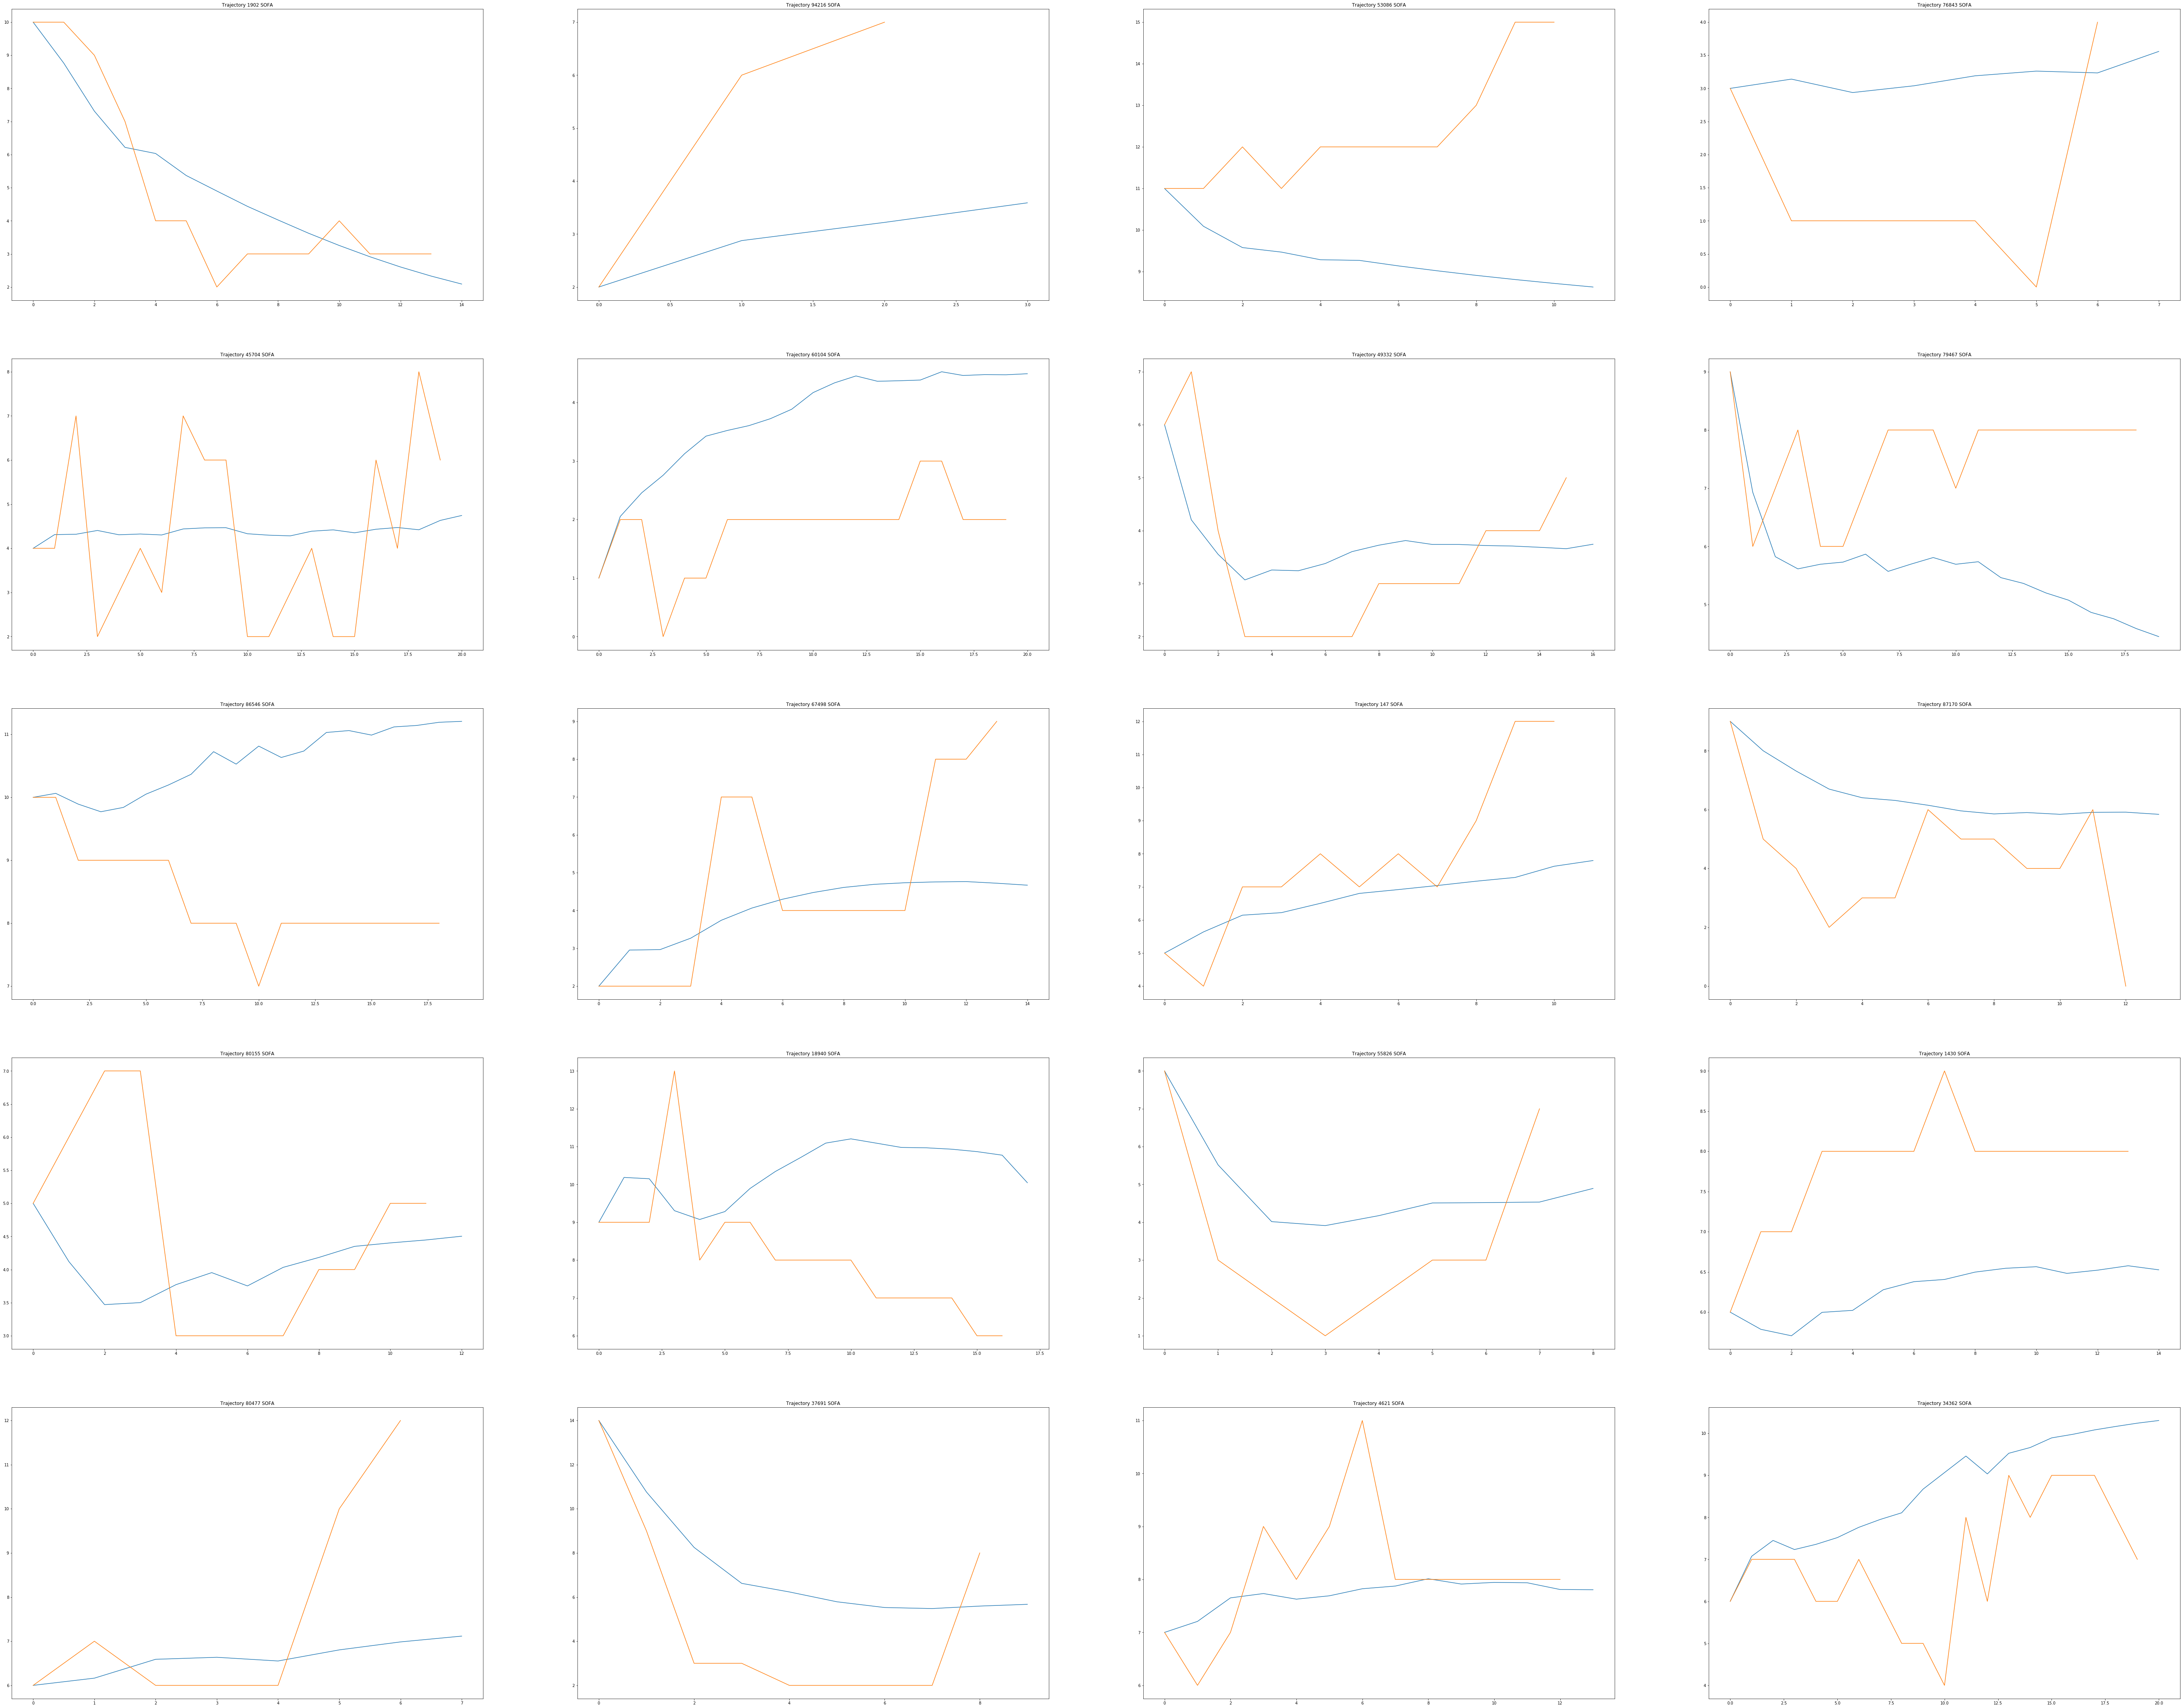

In [218]:
# make some plots
f, ax_arr = plt.subplots(5,4, figsize=(100,80))
unrolled_ax_arr = ax_arr.reshape(-1)
for i, traj_id in enumerate(traj_ids):
    ax = unrolled_ax_arr[i]
    rollout = rollouts[i]
    rel_segment = rel_entries.loc[rel_entries['icustayid']==traj_id]
    sofa_pred = rollout[:,179]*sofa_std + sofa_mean
    sofa_actual = rel_segment['SOFA'].values*sofa_std + sofa_mean
    ax.plot(sofa_pred)
    ax.plot(sofa_actual)
    ax.set_title("Trajectory %d SOFA" % traj_id)

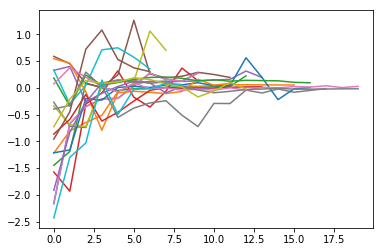

In [215]:
for rollout in rollouts:
    res = rollout[:,179]*sofa_std + sofa_mean
    res2 = np.copy(res)
    res = res[:-1]
    res2 = res2[1:]
    plt.plot(res2-res)
#     plt.show
    